### Agentic RAG
🤖 What is Agentic RAG?

Agentic RAG stands for Agentic Retrieval-Augmented Generation — an advanced version of RAG where instead of a static, one-shot LLM response,the system uses an agent that:

- reasons,
- plans,
- retrieves,
- uses tools,
- and even retries or reflects
to generate better, more grounded answers.

In [1]:
import os
from typing import List, Annotated
from pydantic import BaseModel

from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain.schema import Document
from langgraph.graph import StateGraph, END

USER_AGENT environment variable not set, consider setting it to identify your requests.
/home/miguel/miniconda3/envs/RAG/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x7d4d1c16b550>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7d4d1bc67690>, root_client=<openai.OpenAI object at 0x7d4d1c16ac90>, root_async_client=<openai.AsyncOpenAI object at 0x7d4d1bc67290>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [3]:
# -----------------------------
# 1. Document Preprocessing
# -----------------------------
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

loaders = [WebBaseLoader(url) for url in urls]
docs = []
for loader in loaders:
    docs.extend(loader.load())

docs


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [4]:
## Recursive character text ssplitter an vectorstore
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
split_docs = splitter.split_documents(docs)

embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(split_docs, embedding)
retriever = vectorstore.as_retriever()

In [5]:
retriever.invoke("What are agents")

[Document(id='65e1a845-a59c-4add-921e-02c5e0317df7', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [6]:
# -----------------------------
# 2. Define RAG State
# -----------------------------

class RAGState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""

In [7]:
# -----------------------------
# 3. LangGraph Nodes
# -----------------------------

def retrieve_docs(state: RAGState) -> RAGState:
    docs = retriever.invoke(state.question)
    return RAGState(question=state.question, retrieved_docs=docs)

def generate_answer(state: RAGState) -> RAGState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"Answer the question based on the context.\n\nContext:\n{context}\n\nQuestion: {state.question}"
    response = llm.invoke(prompt)
    return RAGState(question=state.question, retrieved_docs=state.retrieved_docs, answer=response.content)

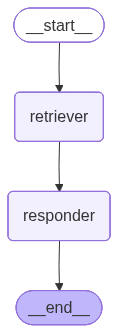

In [8]:
# -----------------------------
# 4. Build LangGraph
# -----------------------------

builder = StateGraph(RAGState)

builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)

builder.set_entry_point("retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

In [9]:
# -----------------------------
# 5. Run the Agentic RAG
# -----------------------------

if __name__ == "__main__":
    user_question = "What is the concept of agent loop in autonomous agents?"
    initial_state = RAGState(question=user_question)
    final_state = graph.invoke(initial_state)

    print("\n✅ Final Answer:\n", final_state['answer'])


✅ Final Answer:
 The concept of an agent loop in autonomous agents refers to the continuous cycle of perception, decision-making, and action that these agents undergo. This loop allows agents to interact with their environment and other agents in a dynamic way. It typically involves the following steps: perceiving the environment or gathering input, processing this information using memory, planning, and reflection mechanisms, making decisions based on past experiences and learned reflections, taking actions accordingly, and then updating memory and knowledge to improve future interactions. This iterative loop is crucial for agents to autonomously adapt and improve in real-time, and is particularly important in complex or real-world tasks where continual learning from experiences and adjusting strategies is necessary.


In [10]:
final_state

{'question': 'What is the concept of agent loop in autonomous agents?',
 'retrieved_docs': [Document(id='b3c90bb6-fc20-402b-bc40-326a0a526576', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism an

### 🤖 What is ReAct?
ReAct (Reasoning + Acting) is a framework where an LLM:

- Reasons step-by-step (e.g. decomposes questions, makes decisions)

- Acts by calling tools like search, calculators, or retrievers

This makes it perfect for Agentic RAG:
✅ Think → Retrieve → Observe → Reflect → Final Answer